In [1]:
import os
import tempfile
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi
import seaborn as sns
import torch
import pertpy as pt

import muon as mu

from _quasiSCVI import QuasiSCVI
from _quasivae import QuasiVAE


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.3


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Here we use the pancreas dataset described in the [scIB](https://github.com/theislab/scib) manuscript, that is also widely used to benchmark integration methods.

In [4]:
mdata = pt.dt.papalexi_2021()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name beca

In [5]:
mdata["rna"]

sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])
sc.pp.highly_variable_genes(mdata["rna"],n_top_genes=2000, batch_key="replicate",  subset=True)


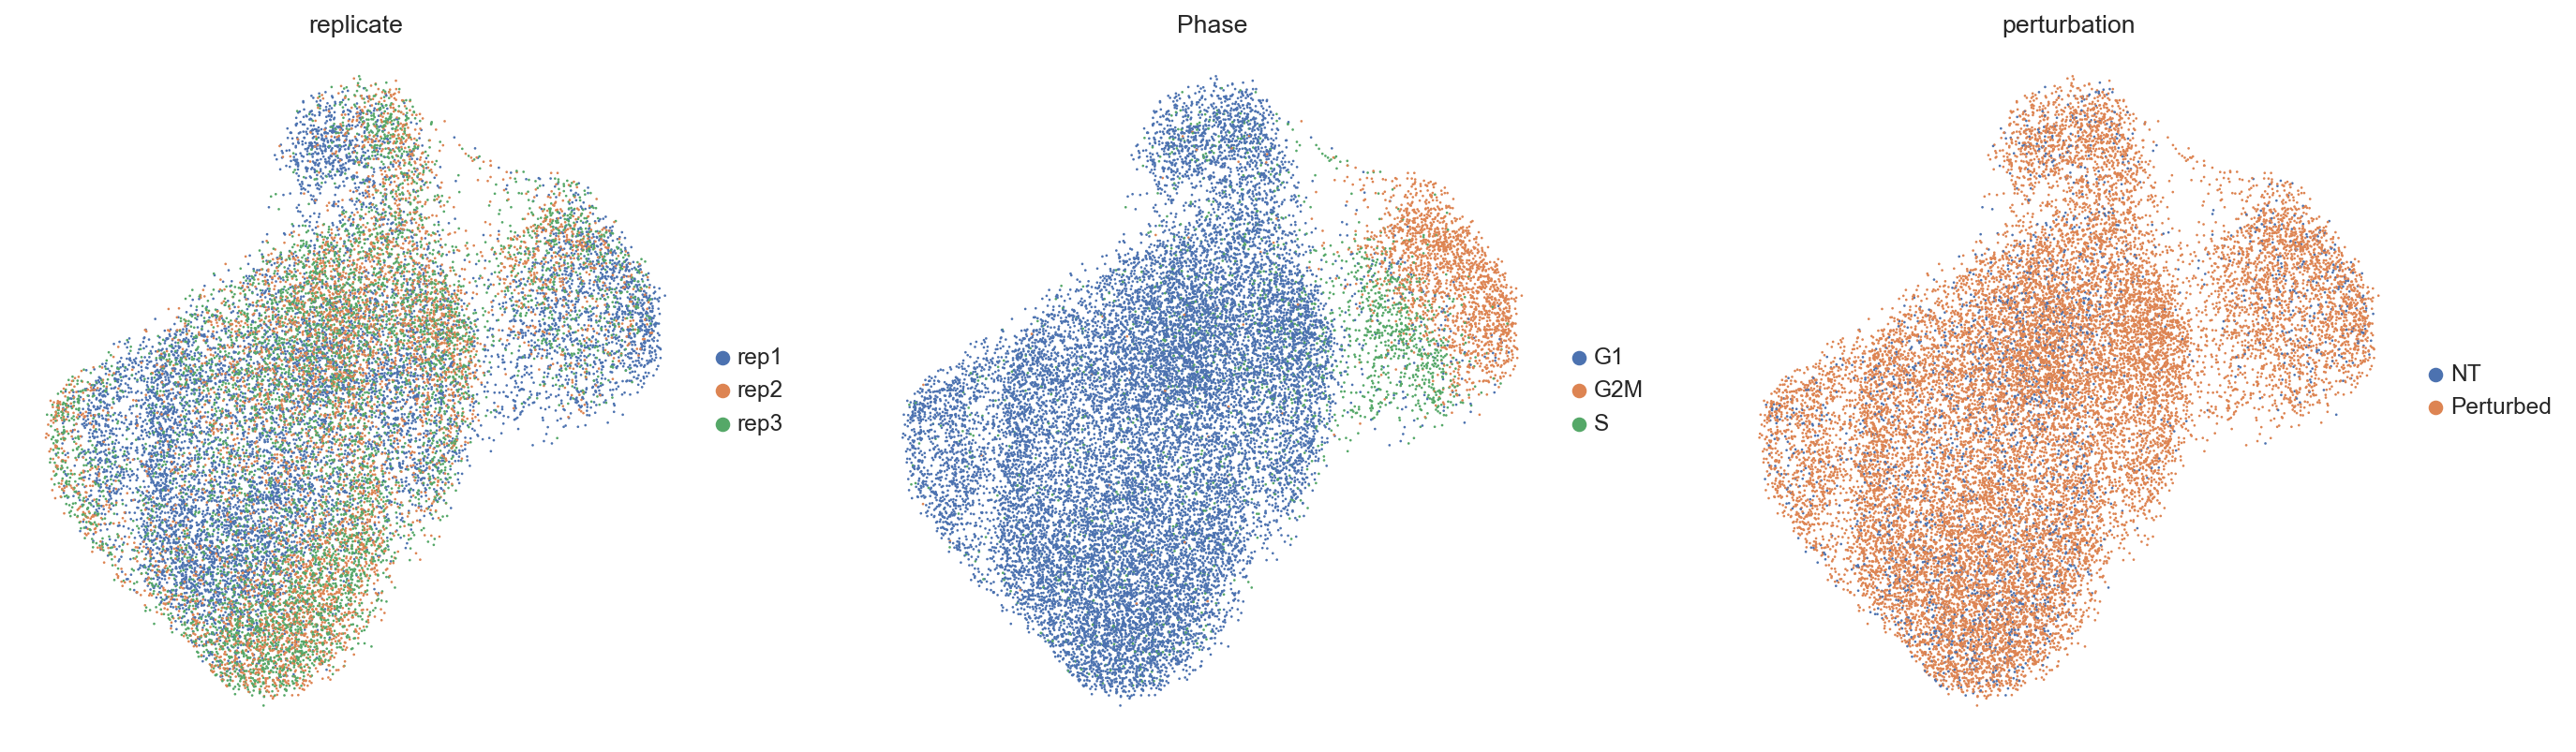

In [6]:
sc.pp.pca(mdata["rna"])
sc.pp.neighbors(mdata["rna"], metric="cosine")
sc.tl.umap(mdata["rna"])
sc.pl.umap(mdata["rna"], color=["replicate", "Phase", "perturbation"])

In [7]:
mdata["rna"]


AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'replicate_colors', 'Phase_colors', 'perturbation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
mdata_ref = mdata["rna"].copy()

In [9]:
#### Quasi Likelihood Model

In [10]:
QuasiSCVI.setup_anndata(mdata_ref, batch_key="replicate")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [11]:
# Initialize the Quasi SCVI model
scvi_ref = QuasiSCVI(
    mdata_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

# Train the model
scvi_ref.train(max_epochs=400, plan_kwargs={"lr": 1e-4})

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|███████████████████████████████████████| 400/400 [20:02<00:00,  3.09s/it, v_num=1, train_loss_step=0.582, train_loss_epoch=0.619]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████| 400/400 [20:02<00:00,  3.01s/it, v_num=1, train_loss_step=0.582, train_loss_epoch=0.619]


In [12]:
scvi_ref.history["elbo_train"]
train_loss = scvi_ref.history["elbo_train"]
kl_divergence = scvi_ref.history["kl_local_train"]

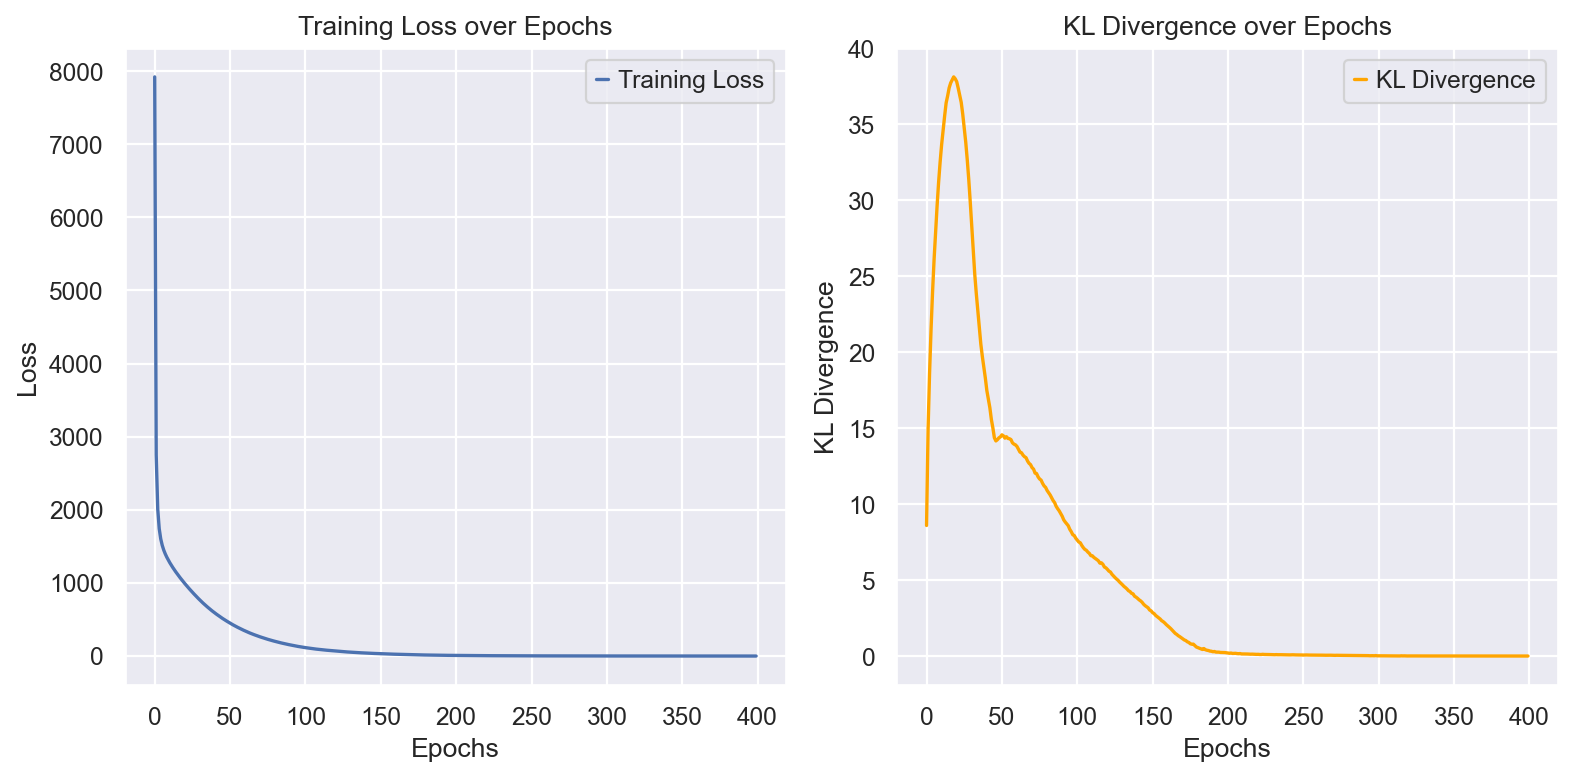

In [13]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot KL divergence
plt.subplot(1, 2, 2)
plt.plot(kl_divergence, label='KL Divergence', color='orange')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [14]:
SCVI_LATENT_KEY = "X_scVI"

mdata_ref.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(mdata_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(mdata_ref)
sc.tl.umap(mdata_ref)

/var/folders/3k/yfw07yqn6nbdwjkxhf022b2m0000gn/T/ipykernel_61098/1824613379.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(mdata_ref)


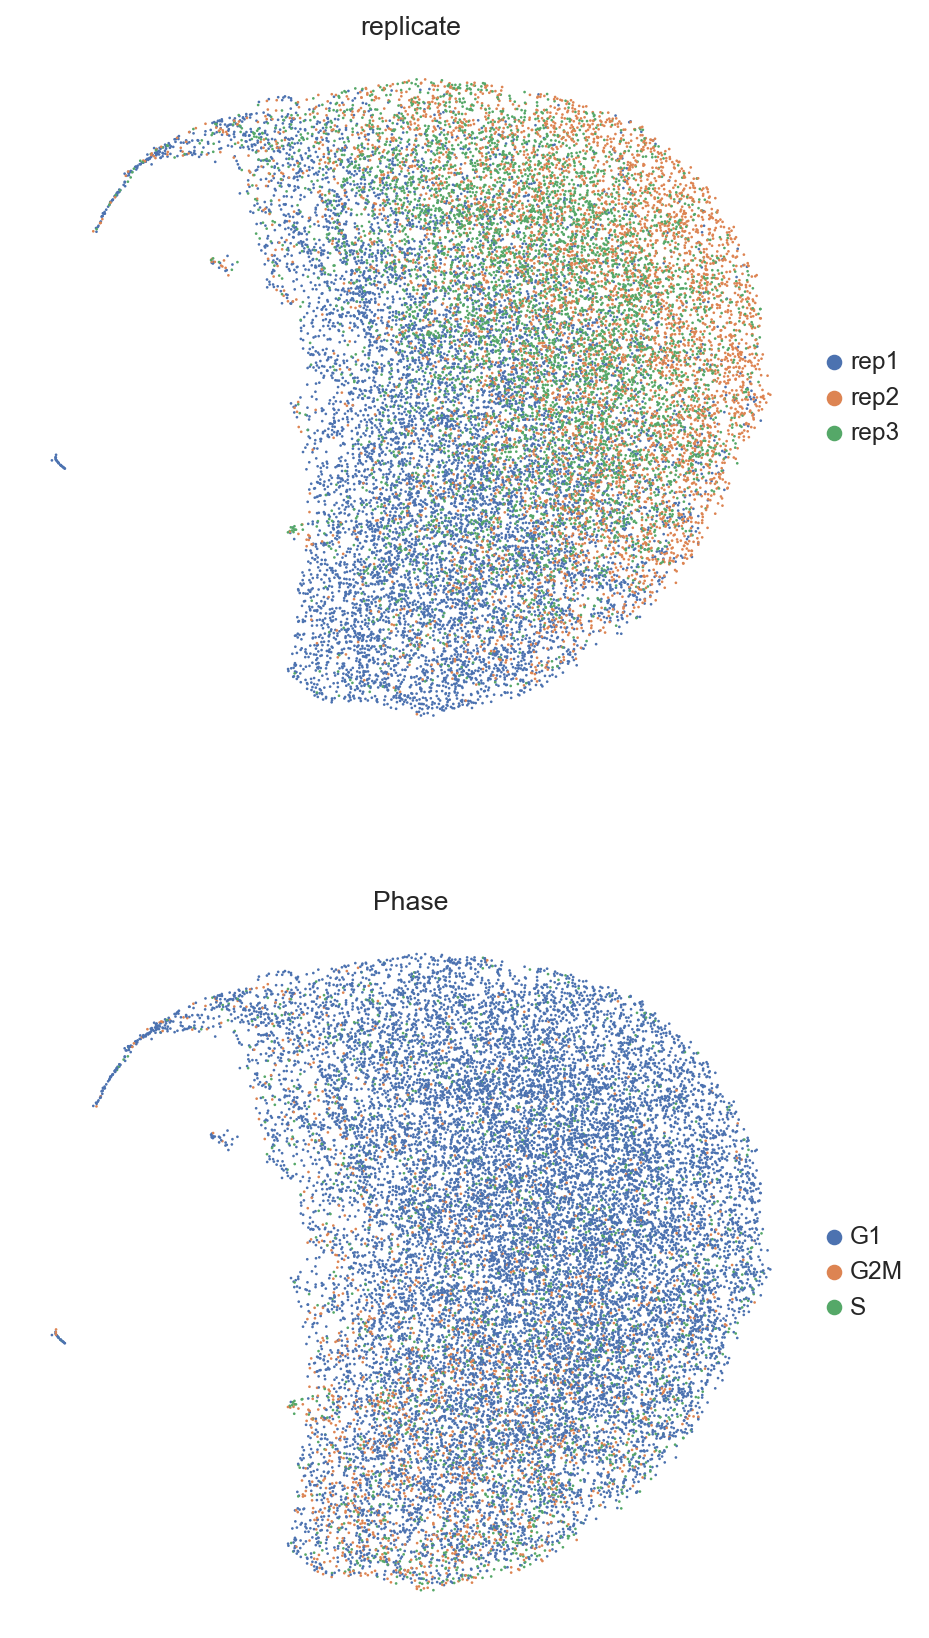

In [15]:
sc.pl.umap(
    mdata_ref,
    color=["replicate","Phase"],
    frameon=False,
    ncols=1,
)